In [35]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

# importe le simulateur depuis simulateur.py
from simulateur import *

# importe l'algorithme RRT*
from PythonRobotics.PathPlanning.RRTStar.rrt_star import RRTStar

from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Préparer la carte

In [ ]:
# Cell Dimension: 633, 1149

# importing the map and droping the last empty column
df = pd.read_csv('maps/RDCmod3.txt', header=None)
df = df.drop(columns=[633])

# droping columns and rows with 0
df = df.loc[:, (df != 0).any(axis=0)]
df = df.loc[(df!=0).any(axis=1)]

# reverse the order of the DataFrame, to match the reality
df = df.iloc[::-1]
df.reset_index(inplace=True, drop=True)

#normalizing the dataframe
df_norm = -df.copy()
for column in df_norm.columns:
    df_norm[column] = df_norm[column] / df_norm[column].abs().max()
    
#Rounding the dataframe

#tester en gardant le vide dans la carte, soulage le simulateur ?
df_rounded = df_norm.round(0).astype(int)
df_rounded = df_rounded + 1
df_rounded.replace(2,1, inplace=True)

#Exporting the final map
df_rounded.to_csv("maps/mapnorm.csv",sep=';', header=False, index=False)

In [59]:
dftest = pd.read_csv("maps/mapnorm.csv",sep=';', header=None)

In [ ]:
dftest2 = dftest.copy()

In [ ]:
dftest2

In [ ]:
for y in range(len(dftest)):
    for x in range(len(dftest.iloc[y])):
        if not y==0 and not x==0 and not y==681 and not x==252:
            if(dftest.iloc[y-1][x] == 1 and dftest.iloc[y+1][x] == 1 and dftest.iloc[y][x-1] == 1 and dftest.iloc[y][x+1] == 1):
                dftest2.iloc[y][x] = 0
        else:
            dftest2.iloc[y][x] = 0

In [ ]:
dftest2.to_csv("maps/mapnorm1.csv",sep=';', header=False, index=False)

### Simulation

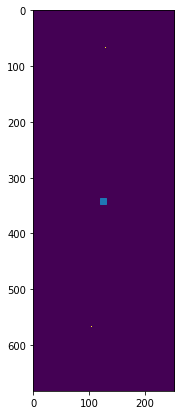

In [58]:
#Création de la pièce et du chien
room = DogRoom('maps/mapnorm2.csv')
# room = DogRoom('maps/map01.csv')
dog = Dog(room, speed=1)
# human = Human(room)

showmap(room,dog)

In [ ]:
room.plotmap()

In [ ]:
# Crée les obstacles
obstacle_list = generateObstacle(room, 1.2)

In [ ]:
showpath(room, dog, goal=[25, 375],  obstacle=[], path=[])

In [ ]:
%matplotlib inline

#définit la destination
# goal = [12,5]
goal = [25, 375]

#crée le chemin
path = generatepath(room, dog, goal, obstacle_list, max_iter=1000, search_until_max_iter=False)
showpath(room, dog, goal=goal,  obstacle=[], path=path)
#parcourt le chemin
# MoveUsingPath(dog, path)

In [ ]:
MoveUsingPath(room, dog, path)

In [ ]:
# POURQUOI ????
# dog.human()
dog.plotmap()
dog.plotlidar()
dog.plotRGB()
dog.plotdepth()

In [89]:
from scipy import signal

filter_arr = np.array([[0,1,0],[1,1,1],[0,1,0]])

counts = scipy.signal.convolve2d(dftest, filter_arr, mode='same')
counts

array([[3, 4, 4, ..., 4, 4, 3],
       [4, 5, 5, ..., 5, 5, 4],
       [4, 5, 5, ..., 5, 5, 4],
       ...,
       [4, 5, 5, ..., 5, 5, 4],
       [4, 5, 5, ..., 5, 5, 4],
       [3, 4, 4, ..., 4, 4, 3]], dtype=int64)

In [57]:
dftest.to_csv("maps/mapnorm2.csv",sep=';', header=False, index=False)